# Training a Image Classifier for Fashion MNIST Dataset

Shaw And Partners Coding Challenge

Matheus de Andrade Silva

## Dependencies

In [45]:
import pandas as pd
import numpy as np
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

## Import Data

In [66]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = fashion_mnist.load_data()

In [67]:
print('>> Train test size analysis:')
print('Train images shape:', X_train_raw.shape)
print('Train labels shape:', y_train_raw.shape)
print('Test images shape:', X_test_raw.shape)
print('Test labels shape:', y_test_raw.shape)

>> Train test size analysis:
Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


## Data Analysis

In [68]:
print('>> Train label distribution analysis:')
for value in np.array(np.unique(y_train_raw, return_counts=True)).T:
    print(f'Label: {value[0]}, Count: {value[1]}')

>> Train label distribution analysis:
Label: 0, Count: 6000
Label: 1, Count: 6000
Label: 2, Count: 6000
Label: 3, Count: 6000
Label: 4, Count: 6000
Label: 5, Count: 6000
Label: 6, Count: 6000
Label: 7, Count: 6000
Label: 8, Count: 6000
Label: 9, Count: 6000


In [69]:

print('>> Test label distribution analysis:')
for value in np.array(np.unique(y_test_raw, return_counts=True)).T:
    print(f'Label: {value[0]}, Count: {value[1]}')

>> Test label distribution analysis:
Label: 0, Count: 1000
Label: 1, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 5, Count: 1000
Label: 6, Count: 1000
Label: 7, Count: 1000
Label: 8, Count: 1000
Label: 9, Count: 1000


>> Image examples:


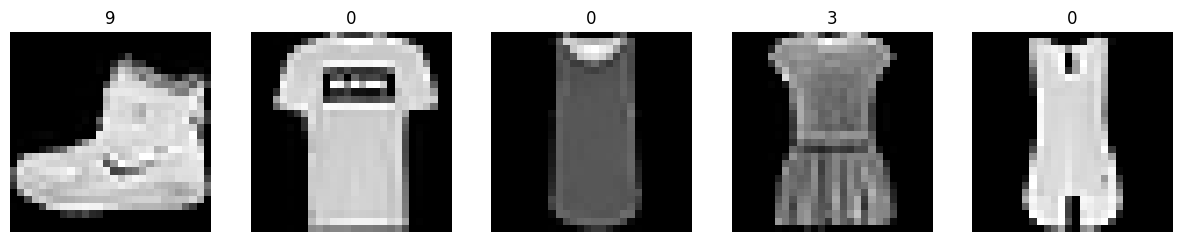

In [70]:
print('>> Image examples:')
fig, axes = plt.subplots(1, 5, figsize=(15,15))
for i in range(5):
    axes[i].imshow(X_train_raw[i], cmap='gray')
    axes[i].set_title(y_train_raw[i])
    axes[i].axis('off')

In [71]:
print('>> Image array data analysis:')
print(f'Image array shape: {X_train_raw[0].shape}')
print(f'Total pixels: {X_train_raw[0].size}')
print(f'Min value: {X_train_raw[0].min()}')
print(f'Max value: {X_train_raw[0].max()}')

>> Image array data analysis:
Image array shape: (28, 28)
Total pixels: 784
Min value: 0
Max value: 255


## Normalize data


In [76]:
# Change the pixel values range from 0-255 to 0-1
X_train = X_train_raw / 255.0
X_test = X_test_raw / 255.0
y_train = y_train_raw
y_test = y_test_raw

## Training

Here I will test some architecture and compare them to choose the best one